In [23]:
from glob import glob
import pandas as pd
import os
from PIL import Image
from tqdm import tqdm
from pathlib import Path
import matplotlib.pyplot as plt

In [24]:

df = pd.read_csv("../data/extracted-blots.csv")

In [27]:
# get resolution from width and height


In [28]:
df["ar"] = df["width"] / df["height"]
df["res"] = df["width"] * df["height"]
blot_meta = df.copy()

- `square`: 0.75 ≤ AR ≤ 1.8
- `tall`: AR < 0.75
- `wide`: 1.8 < AR < 4
- `super_wide`: AR ≥ 4

In [29]:
square_blots = blot_meta.drop(blot_meta[(blot_meta.ar <= 0.75) | (blot_meta.ar >= 1.8)].index)
tall_blots = blot_meta.drop(blot_meta[(blot_meta.ar > 0.75) ].index)
wide_blots = blot_meta.drop(blot_meta[(blot_meta.ar < 1.8)  | (blot_meta.ar > 4)].index)
super_wide_blots = blot_meta.drop(blot_meta[(blot_meta.ar <= 4) ].index)

blot_meta.loc[square_blots.index, 'blot_type'] = 'square'
blot_meta.loc[tall_blots.index, 'blot_type'] = 'tall'
blot_meta.loc[wide_blots.index, 'blot_type'] = 'wide'
blot_meta.loc[super_wide_blots.index, 'blot_type'] = 'super_wide'

<Axes: xlabel='blot_type'>

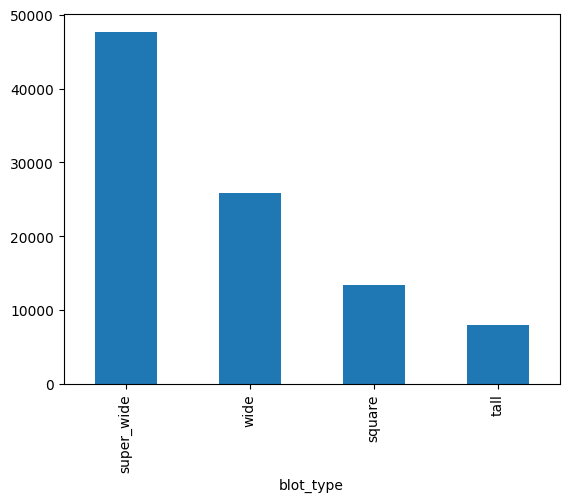

In [30]:
# plot number of blots per type
blot_meta.blot_type.value_counts().plot(kind='bar')

<Axes: >

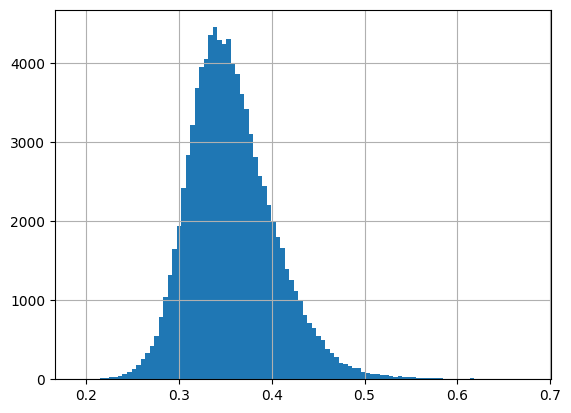

In [31]:
# plot histogram of maniqa-pipal
blot_meta['maniqa-pipal'].hist(bins=100)

<Axes: >

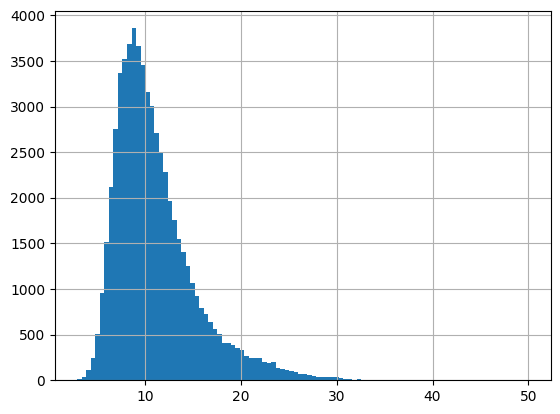

In [32]:
blot_meta[blot_meta['niqe'] <50]['niqe'].hist(bins=100)

<Axes: >

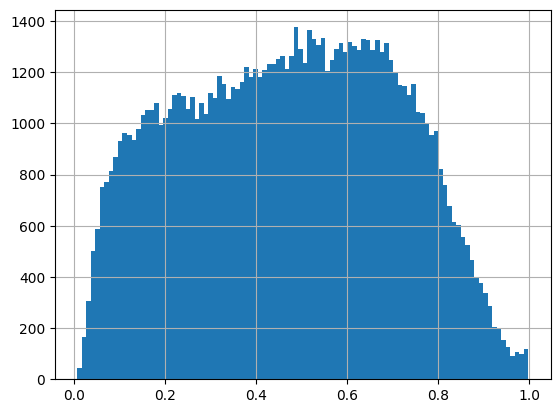

In [33]:
blot_meta[blot_meta['pixelation'] <1]['pixelation'].hist(bins=100)

<Axes: >

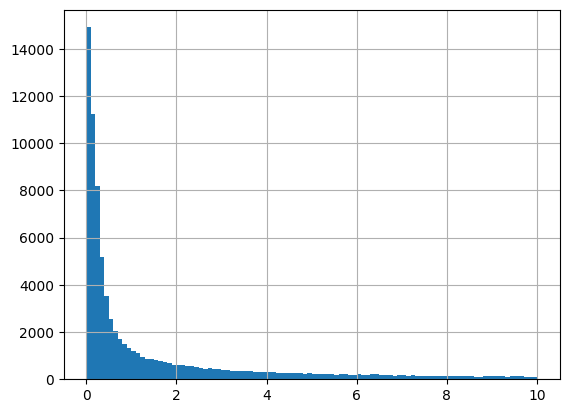

In [34]:

blot_meta[blot_meta['compression'] <10]['compression'].hist(bins=100)

Initial 94942
After Text 90041
After pixelation 8241
After maniqa-pipal 4222
After compression 3817
After niqe 2838
Final selection 2838


<Axes: xlabel='blot_type'>

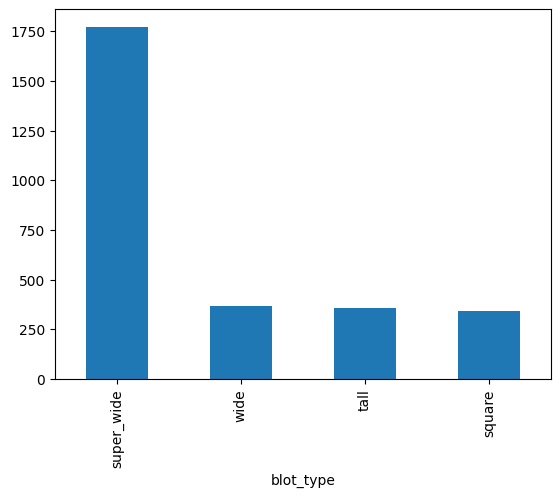

In [101]:
# Approach 1 set the thresholds
# Removes aberrations
selected_data = blot_meta.copy()

print("Initial", len(selected_data))
# Remove images with Text
selected_data = selected_data[selected_data['has_text'] <= 0.3]
print("After Text", len(selected_data))

# Remove images with pixelation effect or totally white
selected_data = selected_data[selected_data['pixelation'] <= 0.14]
print("After pixelation", len(selected_data))

selected_data = selected_data[selected_data['maniqa-pipal'] >= 0.37]
print("After maniqa-pipal", len(selected_data))

selected_data = selected_data[selected_data['compression'] <= 1]
print("After compression", len(selected_data))

selected_data = selected_data[selected_data['niqe'] <= 10.41]
print("After niqe", len(selected_data))

print("Final selection", len(selected_data))
selected_data.blot_type.value_counts().plot(kind='bar')

Initial 94942
After Text 90041
After pixelation 47085
Final selection 27102


<Axes: xlabel='blot_type'>

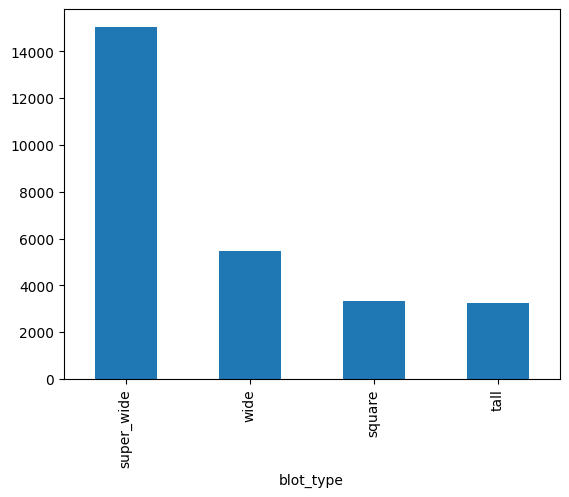

In [102]:
# Removes aberrations, preserve high resolution, soften the thresholds
selected_data = blot_meta.copy()

print("Initial", len(selected_data))
# Remove images with Text
selected_data = selected_data[selected_data['has_text'] <= 0.3]
print("After Text", len(selected_data))

# Remove images with pixelation effect or totally white
selected_data = selected_data[selected_data['pixelation'] <= 0.5]
print("After pixelation", len(selected_data))


selected_data["useful"] = 0
high_resolution =   selected_data[selected_data['res'] > 150000].index
selected_data.loc[high_resolution, "useful"] = 1

maniqa = selected_data[selected_data['maniqa-pipal'] >= 0.37].index
selected_data.loc[maniqa, "useful"] += 1

compression = selected_data[selected_data['compression'] <= 1].index
selected_data.loc[compression, "useful"] += 1

niqe = selected_data[selected_data['niqe'] <= 10.41].index
selected_data.loc[niqe, "useful"] += 1

selected_data = selected_data[selected_data["useful"]>1]
print("Final selection", len(selected_data))
selected_data.blot_type.value_counts().plot(kind='bar')

In [103]:
# split data in two folds
articles = selected_data['article_id'].unique()
articles = {article: selected_data[selected_data['article_id'] == article]["image_path"].tolist() for article in articles}
# sort articles by number of images
articles = {k: v for k, v in sorted(articles.items(), key=lambda item: len(item[1]), reverse=True)}

fold1 = []
fold2 = []

for article, images in articles.items():
    if len(fold1) <= len(fold2):
        fold1 += images
    else:
        fold2 += images

In [104]:
fold1 = selected_data[selected_data['image_path'].isin(fold1)]
fold2 = selected_data[selected_data['image_path'].isin(fold2)]

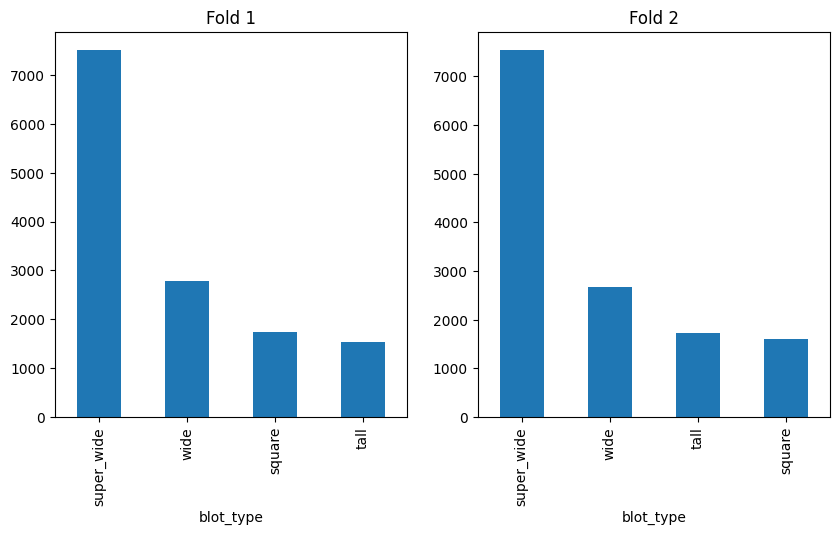

In [105]:
# plot distribution of each fold
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fold1.blot_type.value_counts().plot(kind='bar', ax=ax[0], title="Fold 1")
fold2.blot_type.value_counts().plot(kind='bar', ax=ax[1], title="Fold 2")       
plt.show()

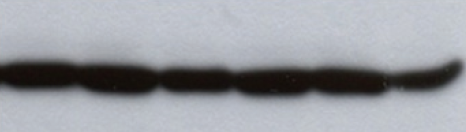

In [99]:
from PIL import Image
Image.open(fold1.sample(1)["image_path"].values[0])